In [ ]:
import numpy as np
import xsimlab as xs

import attr

In [ ]:
@xs.process


In [ ]:
xs.Model({'Flux':Input})

In [2]:
# NOTE: like so! add a CellVariable base class, that each component is initialised as
# this keeps adding to common Grid ! automatically initialises component at each grid point

# what do I need for Term/Fluxes
# generally need to define interactions between CellVariables
# needs to take multiple CellVariables as input, compute a function, and output flux

# for now: solve needs to supply to run_step

@attr.s
class Term:
    var = attr.ib(default=attr.Factory(dict))
    # {'C1':self.component1, 'C2':self.component2}
    args = attr.ib(default=attr.Factory(dict))
    # {'C1':self.arguments1, 'C2':self.arguments2}
    
    @property
    def solve(self):
        """This needs to pass function of ODE to CellVariable"""
        raise NotImplementedError


@xs.process
class Flux:
    """Abstract base class for fluxes, needs to be implemented in subclass"""
    
    flux = xs.any_object("This stores the full Term class of specific flux")
    
    _var = xs.any_object("This contains the actual mathematical formulation described by this term")

    _in = xs.any_object("This handles input (and output) to var")
    
    def _flux(self):
        """mathematical formulation for this term"""
        raise NotImplementedError

    def initialize(self):
        """"""
        self.flux = Term(var=self._var, args=self._in)    
    
    def run_step(self):
        """This needs to calculate specific flux in time step"""
        raise NotImplementedError
        
        
@xs.process
class Input(Flux):
    """Implementation of a simple flux"""
    
    source = xs.variable(intent='in')
    
    rate = xs.variable(intent='in')
    
    component = xs.variable(intent='in')
    
    component_state = xs.foreign(Component, 'state')
    
    def _flux(self):
        """"""
        return self.source * self.rate
        
    def initialize(self):
        """"""
        self._var = {'C':self.flux}
        self._in =  {'C':self.component}
        
        super(Input, self).initialize()
        
        
    def run_step(self):
        """"""
        

In [4]:
@attr.s
class CellVariable:
    dimensions = attr.ib(default=attr.Factory(int))
    # 1,2,3
    fluxes = attr.ib(default=attr.Factory(dict))
    # {'f1':self.func, 'f2':self.flex}
    parameters = attr.ib(default=attr.Factory(dict))
    # {'f1':self.funcpars, 'f2':self.flexpars}
    
    @property
    def solve(self):
        """
        This is called to create system of ode
        
        This needs to collect all fluxes pertaining to a specific component
        """
        raise NotImplementedError


@xs.process
class Component:
    """Abstract base class for components, needs to be implemented in subclass"""
    
    var = xs.any_object("This stores the full CellVariable class of specific flux")
    
    _fluxes = xs.any_object("This contains the actual mathematical formulation described by this term")

    _parameters = xs.any_object("This handles input (and output) to var")
    
    def _flux(self):
        """mathematical formulation for this term"""
        raise NotImplementedError

    def initialize(self):
        """"""
        self.flux = Term(var=self._var, args=self._in)    
    
    def run_step(self):
        """This needs to calculate specific flux in time step"""
        raise NotImplementedError
        
       

In [5]:
xs.Model({'Flux':Input})

<xsimlab.Model (1 processes, 3 inputs)>
Flux
    rate          [in]
    component     [in]
    source        [in]

# Below here: Write solve_ivp() PDE implementation, and then work backwards how to structure base classes!!
### make it compatible with xarray simlab reversely

In [45]:
def f():
    for i in range(N):
        print(i,N)

        
N = 5

f()

0 5
1 5
2 5
3 5
4 5


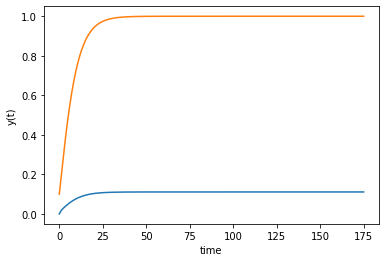

In [115]:
# Just first get chemostat model example to run
import numpy as np

from gekko import GEKKO
import matplotlib.pyplot as plt

m = GEKKO()    # create GEKKO model
k = 0.5        # half-saturation constant
N0 = 1.        # input nutrient concentration
influx = 0.1   # input nutrient flow rate
mortality = 0.1 # phytoplankton mortality

N = m.Array(m.SV,(1,1)) # create GEKKO variable
P = m.SV(.1) # create GEKKO variable
nutlim = m.Intermediate(N[0][0]/(N[0][0]+P))

m.Equation(N[0][0].dt()== N0*influx -  nutlim) # create GEKKO equation
m.Equation(P.dt()==nutlim - mortality*P**2) # create GEKKO equation

m.time = np.linspace(0,175,150) # time points

# solve ODE
m.options.LINEAR = 1
m.options.IMODE = 7
m.solve(disp=False)

# plot results
plt.plot(m.time,N[0][0])
plt.plot(m.time,P)
plt.xlabel('time')
plt.ylabel('y(t)')
plt.show()

In [141]:
import numpy as np
import xsimlab as xs
from gekko import GEKKO
import matplotlib.pyplot as plt

# below here: embed the gekko model in xsimlab!

class Model:
    
    def __init__

@xs.process
class GekkoChemostat:
    
    N = xs.variable()
    
    P = xs.variable()
    
    

SyntaxError: invalid syntax (<ipython-input-141-2918c3f9e8c1>, line 10)

In [20]:
from collections import defaultdict

s = [('yellow', 1), ('blue', 2), ('yellow', 3), ('blue', 4), ('red', 1)]
d = defaultdict(list)

for k, v in s:
    d[k].append(v)

d['yellow'].append(4)

d.items()

dict_items([('yellow', [1, 3, 4]), ('blue', [2, 4]), ('red', [1])])

In [142]:

import numpy as np

In [105]:
from gekko import GEKKO
import numpy as np
import xsimlab as xs

from collections import defaultdict

#from .grid import Grid0D
#from .boundary import Boundary0D


class GekkoInterface:
    """Gekko model context getter/setter that collects processes & parameters
    and creates full gekko model from collected arguments
    """
    
    def __init__(self): 
        self.model = GEKKO()         
        self.context = defaultdict(list)

    def __getitem__(self, key): 
        return self.context[key] 
  
    def __setitem__(self, key, newvalue): 
        self.context[key].append(newvalue)
    
    def __repr__(self):
        return f"gekko context currently stores: {self.context.items()}"
            
    def build_model(self):
        self.model.time = self.context['time']
        [self.model.SV(i) for i in range(x) for x in self.context['c_dims']]
        
        pass
    
    def solve_model(self):
        # how to keep Gekko solution in xsimlab data struct?
        m.solve()
        # this would now modify all the provided 

@xs.process
class Time:
    days = xs.variable(dims='time', description='time in days')
    
    # for indexing xarray IO objects
    time = xs.index(dims='time', description='time in days')
    
    def initialize(self):
        self.time = self.days
        
@xs.process
class Grid0D:
    """Base class, higher dim grids need to inherit and modify"""
    shape = xs.variable(default=1)
    length = xs.variable(default=1)
    
@xs.process
class Boundary0D:
    """Base class, higher dim grids need to inherit and modify"""
    ibc = xs.variable(default=None, description='Initial Boundary Conditions')
        
        
@xs.process
class GekkoContext:
    """This process takes care of proper initialization,
    update and clean-up of gekko PDE/ODE internal
    state.
    """
    time = xs.foreign(Time, 'days')
    
    shape = xs.foreign(Grid0D, 'shape')
    length = xs.foreign(Grid0D, 'length')
    ibc = xs.foreign(Boundary0D, 'ibc')

    context = xs.any_object(
        description='accessor to fastscapelib-fortran internal variables'
    )

    def initialize(self):
        self.context = GekkoInterface()
        
        self.context["time"] = self.time
        
        # freeze context defaultdict after full initialization:
        self.context.default_factory = None
        

    def run_step(self):
        print('step')

    def finalize(self):
        # clean data here, not sure how yet.
        #after full initialization build model:
        self.context.build_model()
        
        print(self.context)
        pass

        
        
@xs.process
class Component:
    gk_context = xs.foreign(GekkoContext, 'context')
    
    label = xs.variable(intent='in')
    init = xs.variable(intent='in')
    dims = xs.variable(intent='in')
    
    c_label = xs.variable(intent='out', groups='c_label')
    c_init = xs.variable(intent='out', groups='c_init')
    
    def initialize(self):
        self.gk_context['statevariables'] = self.label
        
        self.c_label = [f"{self.label}-{i}" for i in range(self.dims)]
        self.c_init = [self.init for i in range(self.dims)]
        
        self.gk_context['c_label'] = self.c_label
        self.gk_context['c_init'] = self.c_init
        self.gk_context['c_dims'] = self.dims
        
        

In [106]:
model = xs.Model({'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 'context':GekkoContext, 'comp':Component})

model

<xsimlab.Model (5 processes, 7 inputs)>
time
    days        [in] ('time',) time in days
grid
    length      [in]
    shape       [in]
ibcs
    ibc         [in] Initial Boundary Conditions
context
comp
    init        [in]
    label       [in]
    dims        [in]

In [107]:
# could wrap this LATER
in_ds = xs.create_setup(
    model=model,
    clocks={'clock': [0, 1]},  # not used but required
    input_vars={
        'time__days': ('time', np.arange(0, 366)),
        'comp':{'init':1,
                'label':'D',
                'dims':4}
    },
    output_vars={}
                 )

In [108]:
with model:
    out_ds = in_ds.xsimlab.run()

step
gekko context currently stores: dict_items([('time', [array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
     

In [124]:
a = defaultdict(object)

In [129]:
a['hi']= np.zeros((3,1))

np.diter(a['hi'])

array([[0.],
       [0.],
       [0.]])

In [ ]:
import numpy as np

arr1 = np.arange(16).reshape(4,4)
arr2 = np.arange(8).reshape(2,4)

In [ ]:
arr1 = np.ones((4,4), dtype = object)

In [ ]:
print(arr1)
print(arr2)

In [ ]:
it1 = np.nditer(arr1, flags=['multi_index','refs_ok'])
it2 = np.nditer(arr2, flags=['multi_index','refs_ok'])
print(it1.ndim)
print(it1.itersize)
print(it2.ndim)
print(it2.itersize)

In [5]:
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

m = GEKKO()    # create GEKKO model


In [ ]:
while not it1.finished:
    while not it2.finished:
        print('it1',it1[0], it1.multi_index)
        print('it2',it2[0], it2.multi_index)
        arr1[it2.multi_index] = m.Intermediate(0)
        print(arr1)
        it2.iternext()
        it1.iternext()

it1 1 (0, 0)
it2 0 (0, 0)
[[0 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
it1 1 (0, 1)
it2 1 (0, 1)
[[0 0 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
it1 1 (0, 2)
it2 2 (0, 2)
[[0 0 0 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
it1 1 (0, 3)
it2 3 (0, 3)
[[0 0 0 0]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
it1 1 (1, 0)
it2 4 (1, 0)
[[0 0 0 0]
 [0 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
it1 1 (1, 1)
it2 5 (1, 1)
[[0 0 0 0]
 [0 0 1 1]
 [1 1 1 1]
 [1 1 1 1]]
it1 1 (1, 2)
it2 6 (1, 2)
[[0 0 0 0]
 [0 0 0 1]
 [1 1 1 1]
 [1 1 1 1]]
it1 1 (1, 3)
it2 7 (1, 3)
[[0 0 0 0]
 [0 0 0 0]
 [1 1 1 1]
 [1 1 1 1]]


In [ ]:
print(arr1)

In [111]:
# Just first get chemostat model example to run
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

m = GEKKO()    # create GEKKO model

k = 0.5        # half-saturation constant
N0 = 1.        # input nutrient concentration
influx = 0.1   # input nutrient flow rate
mortality = 0.1 # phytoplankton mortality

ni = 1  # number of rows
nj = 1  # number of columns

# best method: use m.Array function
N = m.Array(m.Var,(ni,nj),lb=0)
P = m.Array(m.Var,(ni,nj),lb=0)

for i in np.diter(ni):
    for j in range(nj):
        N[i,j].value = 5.0
        P[i,j].value = .1
        
def nutlim(N,P,i,j):
    return(N[i][j]/(N[i][j]+P[i][j]))


m.Equations([N[i][j].dt()==- N[i][j]/(N[i][j]+P[i][j]) for i in range(ni) for j in range(nj)])
m.Equations([P[i][j].dt()==N[i][j]/(N[i][j]+P[i][j]) - mortality*P[i][j]  for i in range(ni) for j in range(nj)])

m.time = np.arange(0,175) # time points

# solve ODE
m.options.IMODE = 7
m.solve()

apm 75.80.96.79_gk_model26 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            2
   Intermediates:            0
   Connections  :            0
   Equations    :            2
   Residuals    :            2
 
 Number of state variables:              4
 Number of total equations: -            4
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Sequential Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains

In [17]:
import numpy as np
from gekko import GEKKO

m = GEKKO()

# Random 3x3
A = np.random.rand(3,3)
# Random 3x1
b = np.random.rand(3)
# Gekko array 3x1
x = m.Array(m.Var,(3))

# solve Ax = b
eqn = np.dot(A,x)
for i in range(3):
    m.Equation(eqn[i]==b[i])
m.solve(disp=False)
X = [x[i].value for i in range(3)]
print(X)
print(b)
print(np.dot(A,X))

[[0.84156108574], [0.57577937977], [-1.2888112755]]
[0.28744558 0.3467906  0.03681696]
[[0.28744558]
 [0.3467906 ]
 [0.03681696]]


In [38]:
import numpy as np
from gekko import GEKKO

import matplotlib.pyplot as plt

m = GEKKO()

a = 1.
b = m.Var()
C = m.Var()

components_L = [a] + [2]
components_R = {a ,a, 2*a}

component_left = [comp for comp in components_L] 
component_right = [comp for comp in components_R] 

m.Equations(C.dt() == (v for v in components_R) )

#m.Equation(C>=b)

m.time = np.arange(0,175) # time points

# solve ODE
m.options.IMODE = 7
m.solve(disp=False)

print(C, b, m.time.shape)
plt.plot(m.time,C)
plt.show()

TypeError: 'int' object is not subscriptable

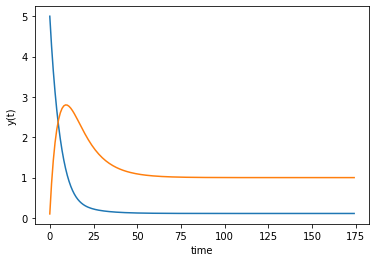

In [18]:
# plot results
plt.plot(m.time,N[0][0])
plt.plot(m.time,P[0][0])
plt.xlabel('time')
plt.ylabel('y(t)')
plt.show()

In [11]:
import numpy as np
import scipy.optimize as opt
from gekko import GEKKO

p= np.array([4, 5, 6.65, 12]) #p = prices
pmx = np.triu(p - p[:, np.newaxis]) #pmx = price matrix, upper triangular

m = GEKKO()
q = m.Array(m.Var,(4,4),lb=0,ub=10)
# only upper triangular can change
for i in range(4):
    for j in range(4):
        if j<=i:
            q[i,j].upper=0 # set upper bound = 0

def profit(q):
    profit = np.sum(q.flatten() * pmx.flatten())
    return profit

for i in range(4):
    m.Equation(np.sum(q[i,:])<=10)
    m.Equation(np.sum(q[:,i])<=8)

#m.Maximize(profit(q))
print(p)
print(pmx)

m.solve()

print(q)

[ 4.    5.    6.65 12.  ]
[[0.   1.   2.65 8.  ]
 [0.   0.   1.65 7.  ]
 [0.   0.   0.   5.35]
 [0.   0.   0.   0.  ]]
apm 75.80.96.79_gk_model10 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           24
   Intermediates:            0
   Connections  :            0
   Equations    :            8
   Residuals    :            8
 
 Number of state variables:             24
 Number of total equations: -            8
 Number of slack variables: -            8
 ---------------------------------------
 Degrees of freedom       :              8
 
 Number of bound variables: -           10
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 *****

In [ ]:
connect(self,s1,s2)

In [2]:
# Just get 2D chemostat example to run!

import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

m = GEKKO()    # create GEKKO model

k = 0.5        # half-saturation constant
N0 = 1.        # input nutrient concentration
influx = 0.1   # input nutrient flow rate
mortality = 0.1 # phytoplankton mortality

ni = 30  # number of rows
nj = 30  # number of columns

# best method: use m.Array function
N = m.Array(m.Var,(ni,nj))
P = m.Array(m.Var,(ni,nj))

for i in range(ni):
    for j in range(nj):
        N[i,j].value = 5.0
        P[i,j].value = .1
        

In [2]:
for i in range(ni-1):
    for j in range(nj-1):
        m.Equation(N[i,j].dt() == P[i+1,j+1]*0.1)
        m.Equation(P[i,j].dt() == N[i+1,j+1]*0.1)

In [ ]:
#so define boundaries!

# first segment
m.Equation(rho*A*L_seg*cp*T[0].dt() == \
               keff*A*(Th-T[0])/L_seg \
             - keff*A*(T[0]-T[1])/L_seg \
             - heff*As*(T[0]-Ts))
# middle segments
m.Equations([rho*A*L_seg*cp*T[i].dt() == \
               keff*A*(T[i-1]-T[i])/L_seg \
             - keff*A*(T[i]-T[i+1])/L_seg \
             - heff*As*(T[i]-Ts) for i in range(1,seg-1)])
# last segment
m.Equation(rho*A*L_seg*cp*T[seg-1].dt() == \
             keff*A*(T[seg-2]-T[seg-1])/L_seg \
           - heff*(As+A)*(T[seg-1]-Ts))

In [3]:
m.time = np.arange(0,175) # time points

# solve ODE
m.options.IMODE = 7
m.solve()

apm 75.80.96.79_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :         1800
   Intermediates:            0
   Connections  :            0
   Equations    :         1682
   Residuals    :         1682
 
 Number of state variables:           3482
 Number of total equations: -         3364
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :            118
 
 @error: Degrees of Freedom
 * Error: DOF must be zero for this mode
 STOPPING...


Exception:  @error: Degrees of Freedom
 * Error: DOF must be zero for this mode
 STOPPING...


In [22]:
m.Equations([N[i][j].dt()==0 for i in range(ni) for j in range(nj)])

print('OK')

OK


In [ ]:
def nutlim(N,P,i,j):
    return(N[i][j]/(N[i][j]+P[i][j]))

def advection(state):
    # Propagate with forward-difference in time, central-difference in space
    advect = self.exchange_rate  * (
      (state[2:, 1:-1] - 2*state[1:-1, 1:-1] + state[:-2, 1:-1])/dx**2 
      + (state[1:-1, 2:] - 2*state[1:-1, 1:-1] + state[1:-1, :-2])/dy**2 )
    
    return advect


m.Equations(np.asarray(N).dt()==0)

m.time = np.arange(0,175) # time points

# solve ODE
m.options.IMODE = 7
m.solve()

In [ ]:
from gekko import GEKKO

m = GEKKO()

ni = 3  # number of rows
nj = 2  # number of columns

# best method: use m.Array function
x = m.Array(m.Var,(ni,nj))
m.Equations([x[i][j]==i*j+1 for i in range(ni) for j in range(nj)])

# another way: list comprehensions
y = [[m.Var() for j in range(nj)] for i in range(ni)]
for i in range(ni):
    for j in range(nj):
        m.Equation(x[i][j]**2==y[i][j])

# summation
z = m.Var()
m.Equation(z==sum([sum([x[i][j] for i in range(ni)]) for j in range(nj)]))

m.solve()

print('x:')
print(x)
print('y=x**2:')
print(y)
print('z')
print(z.value)

In [47]:
for i in range(ni):
    for j in range(nj):
        m.Equation(xchange[i][j].dt()== exchange_rate * (
            x[i+1][j-1])

[m.Equation(v[i+1].dt()== \
            c**2 * (u[i+2] - 2.0*u[i+1] + u[i])/dx**2) \
            for i in range(npx-2) ]
m.Equation(v[npx-1].dt()== c**2 * \
           (u[npx-2] - 2.0*u[npx-1] + u[0])/dx**2 )

m.Equation(xchange.dt()== advection(x))
m.Equation(ychange.dt()== advection(y))
                   
                   # gridExchanges
xchange = m.Array(m.Var,(ni,nj))
ychange = m.Array(m.Var,(ni,nj))

                   
                   
def advection(state):
    dx = 1
    dy = 1
    # Propagate with forward-difference in time, central-difference in space
    advect = self.exchange_rate  * (
      (state[2:, 1:-1] - 2*state[1:-1, 1:-1] + state[:-2, 1:-1])/dx**2 
      + (state[1:-1, 2:] - 2*state[1:-1, 1:-1] + state[1:-1, :-2])/dy**2 )
    return advect

0.4624000000000001

In [26]:
# Gekko Model construction workflow:
import numpy as np
# 1. import gekko and create model:
from gekko import GEKKO
from gekko import chemical
m = GEKKO()

# 2. define full model dimensionality
ni = 30  # number of rows
nj = 30  # number of columns


xchange = m.Array(m.Var,(ni,nj))

# initialise components:
x = m.Array(m.SV,(ni,nj))

# init
for i in range(ni):
    for j in range(nj):
        
        x[i,j].value = 5.0
        x[i,3].value = 2.0
        x[i,4].value = 2.0
        x[i,5].value = 2.0
        x[i,6].value = 2.0
        # gridxchange
        xchange[i,j].value = 0

#define component_fluxes within grid_cells
for i in range(ni):
    for j in range(nj):
        m.Equation(x[i][j].dt()== xchange[i,j])  # x[i][j]*0.1 +
        
        
#define component_fluxes within grid_cells
#for i in range(ni):
#    for j in range(nj):
        # edges = 
        
        # else = 
for i in [0,ni-1]:
    for j in range(nj-1):
        #print(i,j)
        m.Equation(xchange[i,j].dt() == 0)
        
for j in [ni-1,0]:
    for i in range(nj-1):
        #print(i,j)
        m.Equation(xchange[i,j].dt() == 0)

for i in range(1,ni-1):
    for j in range(1,nj-1):
        #print(i,j)
        m.Equation(xchange[i,j].dt() == 0.1 * ((x[i+1][j] - 2* x[i,j] + x[i-1,j]) + (x[i][j+1] - 2* x[i,j] + x[i,j-1])) )
        
# provide time to model
time = np.arange(0,10)
m.time = time

m.options.imode = 7

m.solve(disp=False)
print('succesfully solved')

succesfully solved


In [27]:
import matplotlib.pyplot as plt
print('x:')
print(x)

print('xchange:')
#print(xchange[:,0])

x:
[[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
  [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
  [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
  [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 

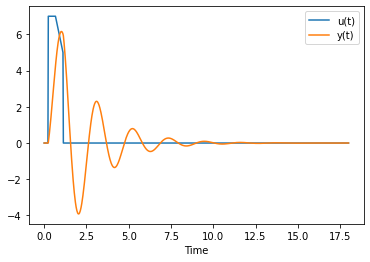

In [78]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

# Create GEKKO model
m = GEKKO()

# Time points for simulation
nt = 810
m.time = np.linspace(0,18,nt)

# Define input
# First step (up) starts at 1 sec
# Ramp (down) starts at 3 sec
# Ramp completes at 5 sec
ut = np.zeros(nt)
ut[11:31] = 7.0
for i in range(31,51):
    ut[i] = ut[i-1] - 0.1

# Define model
u = m.Param(value=ut)
ud = m.Var()
y = m.Var()
dydt = m.Var()
m.Equation(ud==u)
m.Equation(dydt==y.dt())
m.Equation(dydt.dt() + 1*y.dt() + 9*y == 1*ud.dt()+5*u)

# Simulation options
m.options.IMODE=7
m.options.NODES=4
m.solve(disp=False)

# plot results
plt.figure()
plt.plot(m.time,u.value,label='u(t)')
plt.plot(m.time,y.value,label='y(t)')
plt.legend()
plt.xlabel('Time')
plt.show()

In [81]:
from gekko import GEKKO
m = GEKKO()
# variable array dimension
n = 3 # rows
p = 2 # columns
# create array
x = m.Array(m.Var,(n,p))
for i in range(n):
  for j in range(p):
            x[i,j].value = 2.0
            x[i,j].lower = -10.0
            x[i,j].upper = 10.0
# create parameter
y = m.Param(value = 1.0)
# sum columns
z = [None]*p
print(z)
for j in range(p):
   z[j] = m.Intermediate(sum([x[i,j] for i in range(n)]))

# objective
m.Obj(sum([z[j]**2 + y for j in range(p)]))

# minimize objective
m.options.IMODE=7
m.time = np.arange(1,20)
m.solve()

print(x)

[None, None]
apm 75.80.96.79_gk_model73 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 Current starting time value:    1.00000000000000     
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            7
   Intermediates:            2
   Connections  :            0
   Equations    :            3
   Residuals    :            1
 
 Number of state variables:              6
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              6
 
 @error: Degrees of Freedom
 * Error: DOF must be zero for this mode
 STOPPING...


Exception:  @error: Degrees of Freedom
 * Error: DOF must be zero for this mode
 STOPPING...


In [ ]:
m.time

apm 75.80.96.79_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            2
   Variables    :          200
   Intermediates:            0
   Connections  :            0
   Equations    :          200
   Residuals    :          200
 
 Number of state variables:          79200
 Number of total equations: -        79200
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  3.27575E-21  3.43845E+02
    1  3.27575E-21  3.43845E+02
 Successful solution
 
 -------------------

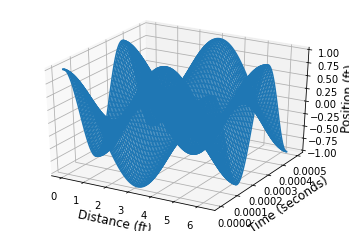

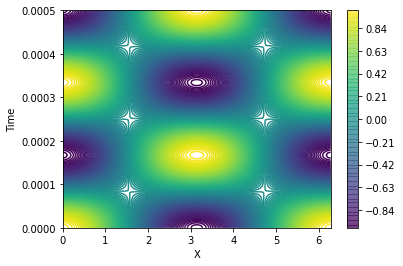

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

from gekko import GEKKO

tf = .0005
npt = 100
xf = 2*np.pi
npx = 100
time = np.linspace(0,tf,npt)
xpos = np.linspace(0,xf,npx)

m = GEKKO()
m.time = time

def phi(x):
    phi = np.cos(x)
    return phi

def psi(x):
    psi = np.sin(2*x)
    return psi

x0 = phi(xpos)
v0 = psi(xpos)
dx = xpos[1]-xpos[0]
a = 18996.06
c = m.Const(value = a)
dx = m.Const(value = dx)
u = [m.Var(value = x0[i]) for i in range(npx)]
v = [m.Var(value = v0[i]) for i in range(npx)]
[m.Equation(u[i].dt()==v[i]) for i in range(npx)]
m.Equation(v[0].dt()==c**2 * \
           (u[1] - 2.0*u[0] + u[npx-1])/dx**2 )
[m.Equation(v[i+1].dt()== \
            c**2 * (u[i+2] - 2.0*u[i+1] + u[i])/dx**2) \
            for i in range(npx-2) ]
m.Equation(v[npx-1].dt()== c**2 * \
           (u[npx-2] - 2.0*u[npx-1] + u[0])/dx**2 )
m.options.imode = 4
m.options.solver = 1
m.options.nodes = 3

m.solve()

# re-arrange results for plotting
for i in range(npx):
    if i ==0:
        ustor = np.array([u[i]])
        tstor = np.array([m.time])
    else:
        ustor = np.vstack([ustor,u[i]])
        tstor = np.vstack([tstor,m.time])
for i in range(npt):
    if i == 0:
        xstor = xpos
    else:
        xstor = np.vstack([xstor,xpos])
xstor = xstor.T
t = tstor
ustor = np.array(ustor)

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.set_xlabel('Distance (ft)', fontsize = 12)
ax.set_ylabel('Time (seconds)', fontsize = 12)
ax.set_zlabel('Position (ft)', fontsize = 12)
ax.set_zlim((-1,1))
p = ax.plot_wireframe(xstor,tstor,ustor,\
                      rstride=1,cstride=1)
fig.savefig('wave_3d.png', Transparent=True)

plt.figure()
plt.contour(xstor, tstor, ustor, 150)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Time')
plt.savefig('wave_contour.png', Transparent=True)
plt.show()